In [1]:
import os
import math
from collections import defaultdict
from typing import List 

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

sns.set_theme(style='whitegrid', font_scale=1.5, palette='muted', rc={'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.abspath(''))
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')

KB = float(1024)
MB = float(KB ** 2)
SECUNDS_IN_MINUTE = 60

titlesize = 16

cols_to_display = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                   'macro avg_precision', 'training_time', 'eval_time',
                   'model_size [MB]', 'gpu_memory_used', 'memory [MB]', 'parameters']

def manage_model_name(name: str) -> str:
    spl = name.split('/')
    if len(spl) == 2:
        return spl[1]
    else:
        return name

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['model_name'] = df['model_name'].apply(lambda x: manage_model_name(x))
    
    df['model_size [MB]'] = df['model_size']/MB
    df['memory [MB]'] = df['memory']/MB
    df['training_time_in_minutes'] = df['training_time']/SECUNDS_IN_MINUTE
    return df

def visualize_models(df: pd.DataFrame, models: List[str], suptitle: str = ''):
        
    df = df[df['model_name'].isin(models)].copy()
    
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = fig.add_gridspec(3, 6)
    
    # Plot measures
    ax1 = fig.add_subplot(gs[0, :])
    
    id_cols = ['name', 'model_name', 'task_name']   
    measures_to_plot = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                    'macro avg_precision']
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)
    
    x_ticks_labels = [col.replace('_',' ').replace('-',' ').capitalize()
                      for col in measures_to_plot]
        
    sns.barplot(x='variable', y='value', hue='model_name', hue_order=models, edgecolor="0",
                data=df_measures, ax=ax1)
    
    if len(models) < 3:
        y_offset = 0.003
        x_offset = 0.1
        for p in ax1.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + y_offset
            value = f'{100*p.get_height():.1f}%'
            ax1.text(_x, _y, value, ha="center") 

    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.set_ylim(bottom=df_measures['value'].min()-0.02)
    ax1.set_xticklabels(x_ticks_labels)
    ax1.set_xlabel('Measure')
    ax1.set_title('Results', fontsize=titlesize)
    ax1.set_ylabel('Value')
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title='Model', bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0.)
    ax1.get_legend().remove()
    
    # Plot training times
    ax2 = fig.add_subplot(gs[1, :3])
    plot_varaible(df, y='training_time_in_minutes', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [min]', title ='Training time', ax=ax2)
    
    # Plot eval times
    ax3 = fig.add_subplot(gs[1, 3:])
    plot_varaible(df, y='eval_time', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [s]', title = 'Eval time', ax=ax3)
    
    # Plot model size
    ax4 = fig.add_subplot(gs[2, :2])   
    plot_varaible(df, y='model_size [MB]', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Size [MB]', title = 'Size on drive', ax=ax4)
    
    # Plot memory usage
    ax5 = fig.add_subplot(gs[2, 2:4])   
    plot_varaible(df, y='memory [MB]', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Memory [MB]', title = 'Memory usage', ax=ax5)
    
    # Plot model size
    ax6 = fig.add_subplot(gs[2, 4:])   
    plot_varaible(df, y='parameters', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Parameters', title = 'Parameters', ax=ax6)
    
    fig.suptitle(suptitle)
#     fig.tight_layout()   
#     file_name = suptitle.replace(':', '').replace(' ','-') + '.pdf'
#     fig.savefig(file_name, bbox_inches='tight')


def visualize_models_comparision(df: pd.DataFrame, reference_model: str, models: List[str], suptitle: str = ''):
    cols = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 'macro avg_precision',
     'training_time_in_minutes', 'eval_time',
        'model_size [MB]', 'memory [MB]', 'parameters']
    
    df = df[df['model_name'].isin(models + [reference_model])].copy()[cols]
    values_for_ref = {c: df[df['model_name'] == reference_model][c].values[0] for c in df.columns}
    
    measures = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 'macro avg_precision']
    for measure in measures:    
        df[measure + '_diff'] = df[measure].apply(lambda x: x - values_for_ref[measure])
        
    for time_measure in ['training_time_in_minutes', 'eval_time']:    
        df[time_measure + '_speedup'] = df[time_measure].apply(lambda x: values_for_ref[time_measure] / x)
        
    for size_measure in ['model_size [MB]', 'memory [MB]', 'parameters']:    
        df[size_measure + '_compression'] = df[size_measure].apply(lambda x: values_for_ref[size_measure] / x)

#     display(df)
    
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = fig.add_gridspec(3, 6)
    
    # Plot measures
    ax1 = fig.add_subplot(gs[0, :])
    
    id_cols = ['model_name']   
    measures_to_plot = [m + '_diff' for m in measures]
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)
        
    x_ticks_labels = [col.replace('_',' ').replace('-',' ').capitalize() for col in measures_to_plot]
    sns.barplot(x='variable', y='value', hue='model_name', hue_order=models, edgecolor="0", data=df_measures, ax=ax1)
    
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.set_xticklabels(x_ticks_labels)
    ax1.set_xlabel('Measure')
    ax1.set_title('Results', fontsize=titlesize)
    ax1.set_ylabel('Value')
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title='Model', bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0.)
    ax1.get_legend().remove()
    
    # Plot training times
    ax2 = fig.add_subplot(gs[1, :3])
    plot_varaible(df, y='training_time_in_minutes_speedup', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Speedup', title ='Training time', ax=ax2)
    
    # Plot eval times
    ax3 = fig.add_subplot(gs[1, 3:])
    plot_varaible(df, y='eval_time_speedup', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Speedup', title = 'Eval time', ax=ax3)
    
    # Plot model size
    ax4 = fig.add_subplot(gs[2, :2])   
    plot_varaible(df, y='model_size [MB]_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Size on drive', ax=ax4)
    
    # Plot memory usage
    ax5 = fig.add_subplot(gs[2, 2:4])   
    plot_varaible(df, y='memory [MB]_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Memory usage', ax=ax5)
    
    # Plot model size
    ax6 = fig.add_subplot(gs[2, 4:])   
    plot_varaible(df, y='parameters_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Parameters', ax=ax6)
    
    fig.suptitle(suptitle)

     
def plot_varaible(data, x, y, order, title='', remove_xticks=False,
                  xlabel=None, ylabel=None, ax=None):
    ax = sns.barplot(x=x, y=y, order=order, data=data, edgecolor="0", ax=ax)
    
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if remove_xticks:   
        ax.set_xticklabels([])
    ax.set_title(title, fontsize=titlesize)
    
    lim_offset = 0.2
    bar_width = 1

    change_width(ax, bar_width)
    left, right = ax.get_xlim()
    ax.set_xlim(left=left-lim_offset, right=right+lim_offset)
    
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)                     # we change the bar width
        patch.set_x(patch.get_x() + diff * .5)         # we recenter the bar
    
def print_model_comparison(df: pd.DataFrame, original_model: str, distilled_model: str):
    results = defaultdict(dict)
    
    for model in [original_model, distilled_model]:
        for col in df.columns:
            value = df[df['model_name']==model][col].values[0]
            results[model][col] = value
            
    title_1 = "Comparison between:"
    title_2 = f"\n - teacher: {original_model.upper()}\n - student: {distilled_model.upper()}\n"
    seperator = "#"*(int(3*len(title_1)))
    
    text = seperator + "\n" + title_1 + title_2
    
    training_time_gain = results[original_model]['training_time_in_minutes'] / results[distilled_model]['training_time_in_minutes']
    text += f"\nTraining time speedup: {training_time_gain:.1f}x faster"
    
    eval_time_gain = results[original_model]['eval_time'] / results[distilled_model]['eval_time']
    text += f"\nEval time speedup: {eval_time_gain:.1f}x faster"
    
    size_gain = results[original_model]['model_size'] / results[distilled_model]['model_size']
    text += f"\nModel size reduction: {size_gain:.1f}x smaller"
    
    quality_retain = results[distilled_model]['macro avg_f1-score'] / results[original_model]['macro avg_f1-score']
    text += f"\nQuality: {100*quality_retain:.1f}% of teacher's performance"
    text += "\n" + seperator 
    
    fig, ax = plt.subplots()
    ax.set_axis_off()    
    ax.text(0.25, 1, text, bbox={'facecolor':'w','pad': 5}, ha="left", va="top", transform=ax.transAxes, fontsize=16)

# Multiemo EN - All sentences

In [3]:
file_name = 'results-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df = load_results_df(file_path)

with pd.option_context('display.max_columns', None):
    display(df)

,name,model_name,task_name,epochs,batch_size,learning_rate,weight_decay,warmup_steps,max_seq_length,training_time,accuracy,eval_time,z_amb_precision,z_amb_recall,z_amb_f1-score,z_amb_support,z_minus_m_precision,z_minus_m_recall,z_minus_m_f1-score,z_minus_m_support,z_plus_m_precision,z_plus_m_recall,z_plus_m_f1-score,z_plus_m_support,z_zero_precision,z_zero_recall,z_zero_f1-score,z_zero_support,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,model_size,gpu_memory_used,memory,parameters,model_size [MB],memory [MB],training_time_in_minutes
0,multiemo_en_all_sentence-run-2,distilbert-base-uncased,multiemo_en_all_sentence,3,16,0.00005,0.01,0,512,607.413427,0.786771,6.896659,0.604895,0.508076,0.552275,681,0.787216,0.864343,0.823978,2123,0.820663,0.829829,0.825221,1522,0.825787,0.758280,0.790595,1419,0.759640,0.740132,0.748017,5745,0.783992,0.786771,0.783855,5745,267866225,8716.0,267826192,66956548,255.457139,255.418961,10.123557
1,multiemo_en_all_sentence-run-1,mobilebert-uncased,multiemo_en_all_sentence,3,16,0.00005,0.01,0,512,2142.272177,0.553699,14.585216,0.272727,0.017621,0.033103,681,0.559515,0.717381,0.628689,2123,0.506952,0.574901,0.538793,1522,0.615323,0.543340,0.577096,1419,0.488630,0.463311,0.444420,5745,0.525379,0.553699,0.521531,5745,98797183,8716.0,98339856,24583940,94.220336,93.784195,35.704536
2,multiemo_en_all_sentence-run-2,bert-base-multilingual-cased,multiemo_en_all_sentence,3,16,0.00005,0.01,0,512,1360.852038,0.765361,13.647752,0.568841,0.461087,0.509327,681,0.772609,0.837023,0.803527,2123,0.803934,0.805519,0.804726,1522,0.789474,0.761099,0.775027,1419,0.733714,0.716182,0.723152,5745,0.760919,0.765361,0.761931,5745,711510189,8716.0,711430160,177856516,678.548993,678.472672,22.680867
3,multiemo_en_all_sentence-run-2,bert-base-uncased,multiemo_en_all_sentence,3,16,0.00005,0.01,0,512,1160.048797,0.790426,13.054379,0.559091,0.541850,0.550336,681,0.820902,0.839849,0.830268,2123,0.827519,0.841656,0.834528,1522,0.811722,0.780832,0.795977,1419,0.754809,0.751047,0.752777,5745,0.789353,0.790426,0.789744,5745,438025389,8716.0,437945360,109485316,417.733563,417.657242,19.334147
4,multiemo_en_all_sentence-run-1,xtremedistil-l6-h256-uncased,multiemo_en_all_sentence,3,16,0.00005,0.01,0,512,354.472152,0.768320,2.434299,0.601594,0.443465,0.510566,681,0.772141,0.845973,0.807372,2123,0.794005,0.818003,0.805825,1522,0.793921,0.754757,0.773844,1419,0.740415,0.715549,0.724402,5745,0.763097,0.768320,0.763498,5745,51049901,8716.0,51008528,12751108,48.684979,48.645523,5.907869
5,multiemo_en_all_sentence-run-1,MiniLM-L12-H384-uncased,multiemo_en_all_sentence,3,16,0.00005,0.01,0,512,678.779967,0.785553,5.748884,0.613309,0.500734,0.551334,681,0.802409,0.847386,0.824284,2123,0.810378,0.831143,0.820629,1522,0.799423,0.780832,0.790018,1419,0.756380,0.740024,0.746566,5745,0.781367,0.785553,0.782497,5745,133530285,8716.0,133450256,33361540,127.344403,127.268082,11.312999
6,multiemo_en_all_sentence-run-1,xtremedistil-l6-h384-uncased,multiemo_en_all_sentence,3,16,0.00005,0.01,0,512,376.218706,0.777894,3.084805,0.674584,0.417034,0.515426,681,0.750498,0.886952,0.813040,2123,0.814910,0.833114,0.823912,1522,0.821287,0.728682,0.772218,1419,0.765320,0.716446,0.731149,5745,0.776048,0.777894,0.770559,5745,90904493,8716.0,90863120,22714756,86.693280,86.653824,6.270312
7,multiemo_en_all_sentence-run-2,distilroberta-base,multiemo_en_all_sentence,3,16,0.00005,0.01,0,512,641.335004,0.786597,6.719052,0.601399,0.505140,0.549082,681,0.813327,0.839378,0.826147,2123,0.814058,0.837057,0.825397,1522,0.789697,0.788584,0.789140,1419,0.754620,0.742539,0.747442,5745,0.782562,0.786597,0.783965,5745,328532077,8716.0,328490016,82121476,313.312604,313.272491,10.688917
8,multiemo_en_all_sentence-run-3,roberta-base,multiemo_en_all_sentence,3,16,0.00005,0.01,0,512,1171.666879,0.806440,12.818568,0.627417,0.524229,0.571200,681,0.839926,0.850212,0.845037,2123,0.821960,0.

In [4]:
df[cols_to_display]

,task_name,model_name,accuracy,macro avg_f1-score,macro avg_recall,macro avg_precision,training_time,eval_time,model_size [MB],gpu_memory_used,memory [MB],parameters
0,multiemo_en_all_sentence,distilbert-base-uncased,0.786771,0.748017,0.740132,0.759640,607.413427,6.896659,255.457139,8716.0,255.418961,66956548
1,multiemo_en_all_sentence,mobilebert-uncased,0.553699,0.444420,0.463311,0.488630,2142.272177,14.585216,94.220336,8716.0,93.784195,24583940
2,multiemo_en_all_sentence,bert-base-multilingual-cased,0.765361,0.723152,0.716182,0.733714,1360.852038,13.647752,678.548993,8716.0,678.472672,177856516
3,multiemo_en_all_sentence,bert-base-uncased,0.790426,0.752777,0.751047,0.754809,1160.048797,13.054379,417.733563,8716.0,417.657242,109485316
4,multiemo_en_all_sentence,xtremedistil-l6-h256-uncased,0.768320,0.724402,0.715549,0.740415,354.472152,2.434299,48.684979,8716.0,48.645523,12751108
5,multiemo_en_all_sentence,MiniLM-L12-H384-uncased,0.785553,0.746566,0.740024,0.756380,678.779967,5.748884,127.344403,8716.0,127.268082,33361540
6,multiemo_en_all_sentence,xtremedistil-l6-h384-uncased,0.777894,0.731149,0.716446,0.765320,376.218706,3.084805,86.693280,8716.0,86.653824,22714756
7,multiemo_en_all_sentence,distilroberta-base,0.786597,0.747442,0.742539,0.754620,641.335004,6.719052,313.312604,8716.0,313.272491,82121476
8,multiemo_en_all_sentence,roberta-base,0.806440,0.767638,0.763154,0.774799,1171.666879,12.818568,475.578534,8716.0,475.501007,124648708
9,multiemo_en_all_sentence,mMiniLMv2-L6-H384-distilled-from-XLMR-Large,0.751958,0.708333,0.699717,0.723959,489.896582,3.089864,408.199323,8716.0,408.159210,106995460


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      15 non-null     object 
 1   model_name                15 non-null     object 
 2   task_name                 15 non-null     object 
 3   epochs                    15 non-null     int64  
 4   batch_size                15 non-null     int64  
 5   learning_rate             15 non-null     float64
 6   weight_decay              15 non-null     float64
 7   warmup_steps              15 non-null     int64  
 8   max_seq_length            15 non-null     int64  
 9   training_time             15 non-null     float64
 10  accuracy                  15 non-null     float64
 11  eval_time                 15 non-null     float64
 12  z_amb_precision           15 non-null     float64
 13  z_amb_recall              15 non-null     float64
 14  z_amb_f1-sco

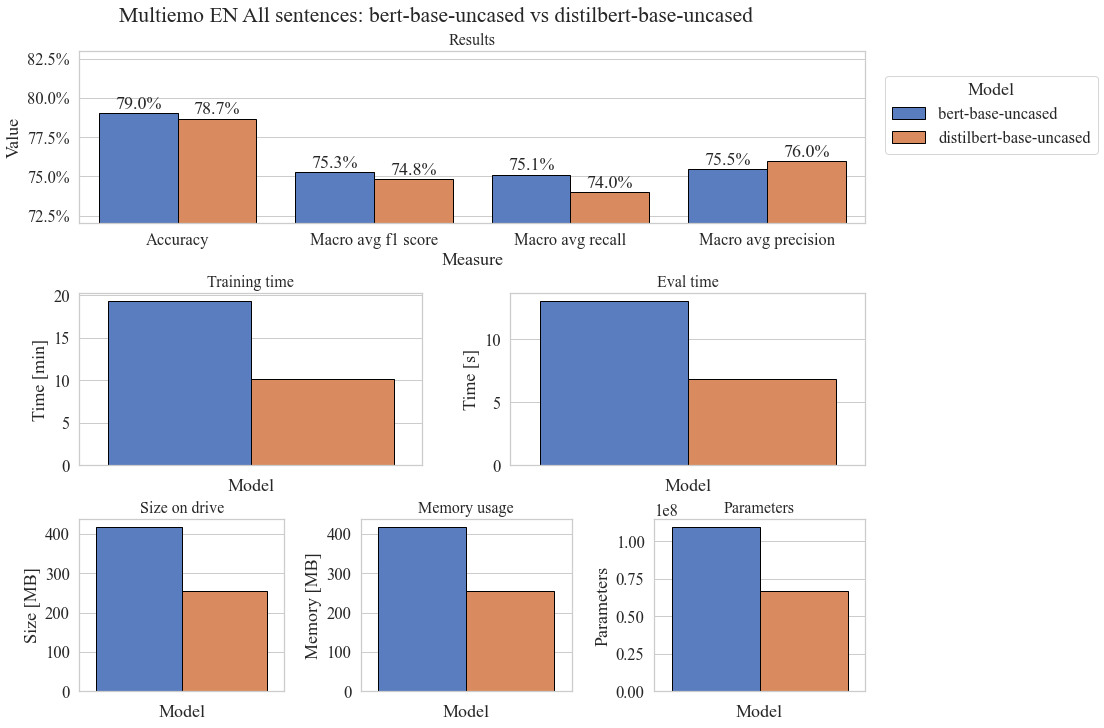

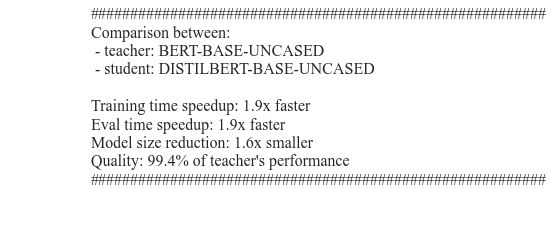

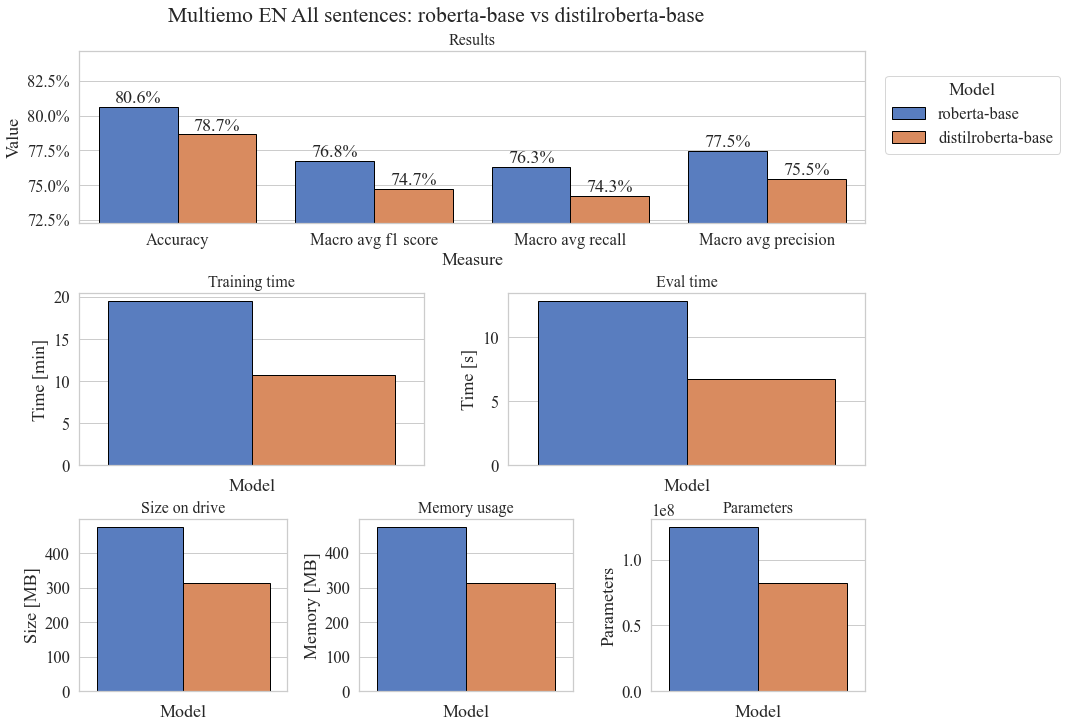

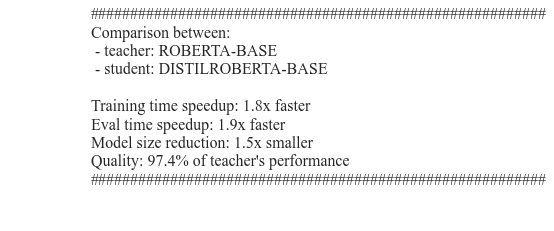

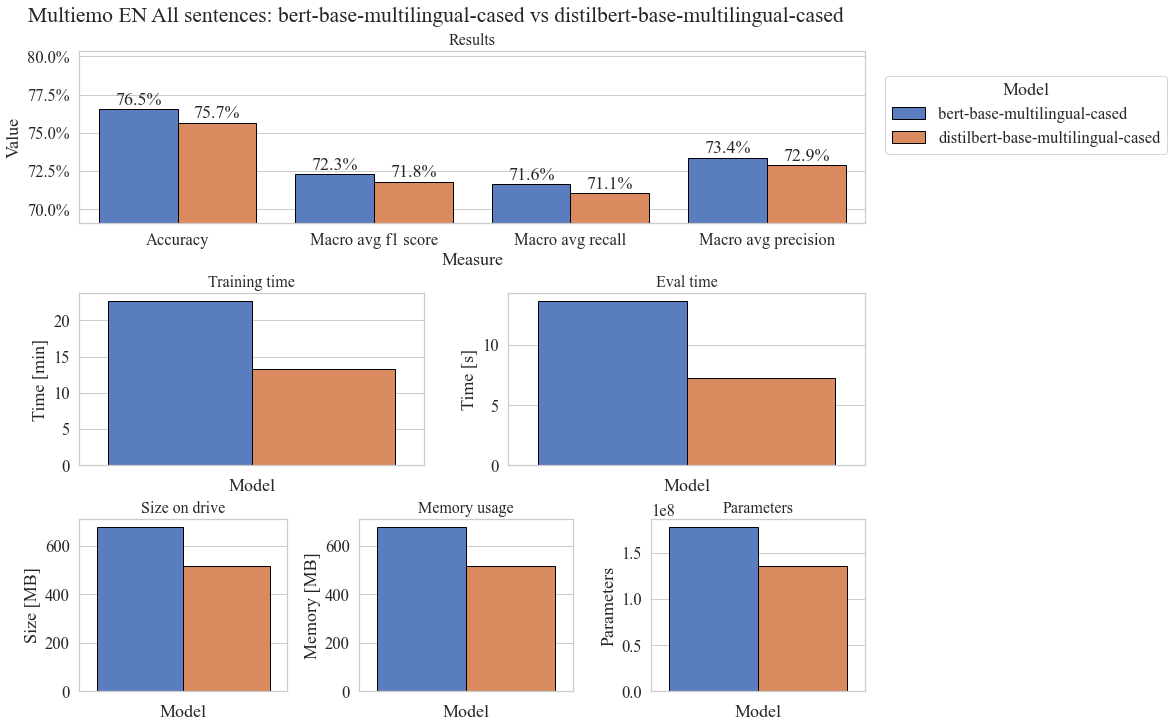

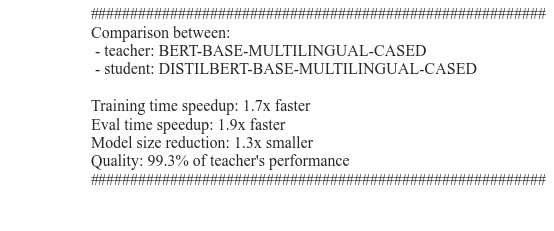

In [6]:
model_pairs = [['bert-base-uncased', 'distilbert-base-uncased'],
               ['roberta-base', 'distilroberta-base'],
               ['bert-base-multilingual-cased', 'distilbert-base-multilingual-cased']]

for models in model_pairs:
    visualize_models(df, models, suptitle='Multiemo EN All sentences: ' + ' vs '.join(models))
    print_model_comparison(df, models[0], models[1])

In [7]:
df['model_name'].values

array(['distilbert-base-uncased', 'mobilebert-uncased',
       'bert-base-multilingual-cased', 'bert-base-uncased',
       'xtremedistil-l6-h256-uncased', 'MiniLM-L12-H384-uncased',
       'xtremedistil-l6-h384-uncased', 'distilroberta-base',
       'roberta-base', 'mMiniLMv2-L6-H384-distilled-from-XLMR-Large',
       'MiniLMv2-L6-H384-distilled-from-BERT-Base',
       'MiniLM-L6-H384-uncased', 'distilbert-base-multilingual-cased',
       'TinyBERT_General_4L_312D', 'TinyBERT_General_6L_768D'],
      dtype=object)

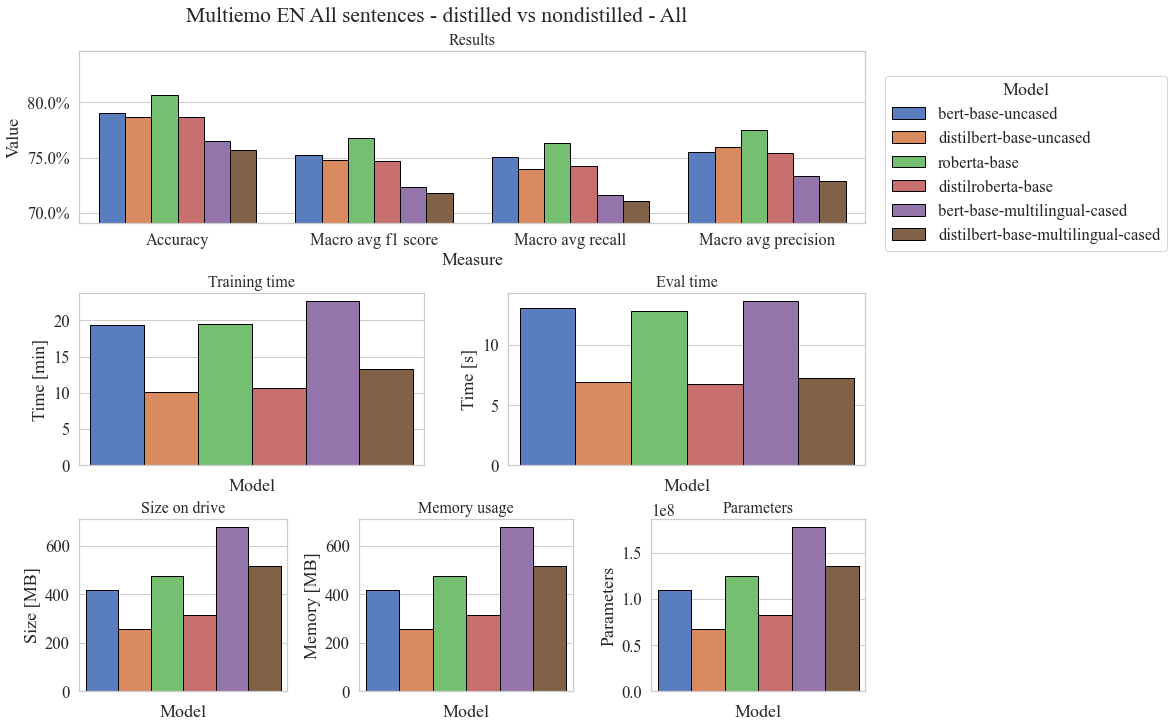

In [8]:
models = ['bert-base-uncased', 'distilbert-base-uncased',
          'roberta-base', 'distilroberta-base',
          'bert-base-multilingual-cased', 'distilbert-base-multilingual-cased',
         ]
visualize_models(df, models, suptitle='Multiemo EN All sentences - distilled vs nondistilled - All')

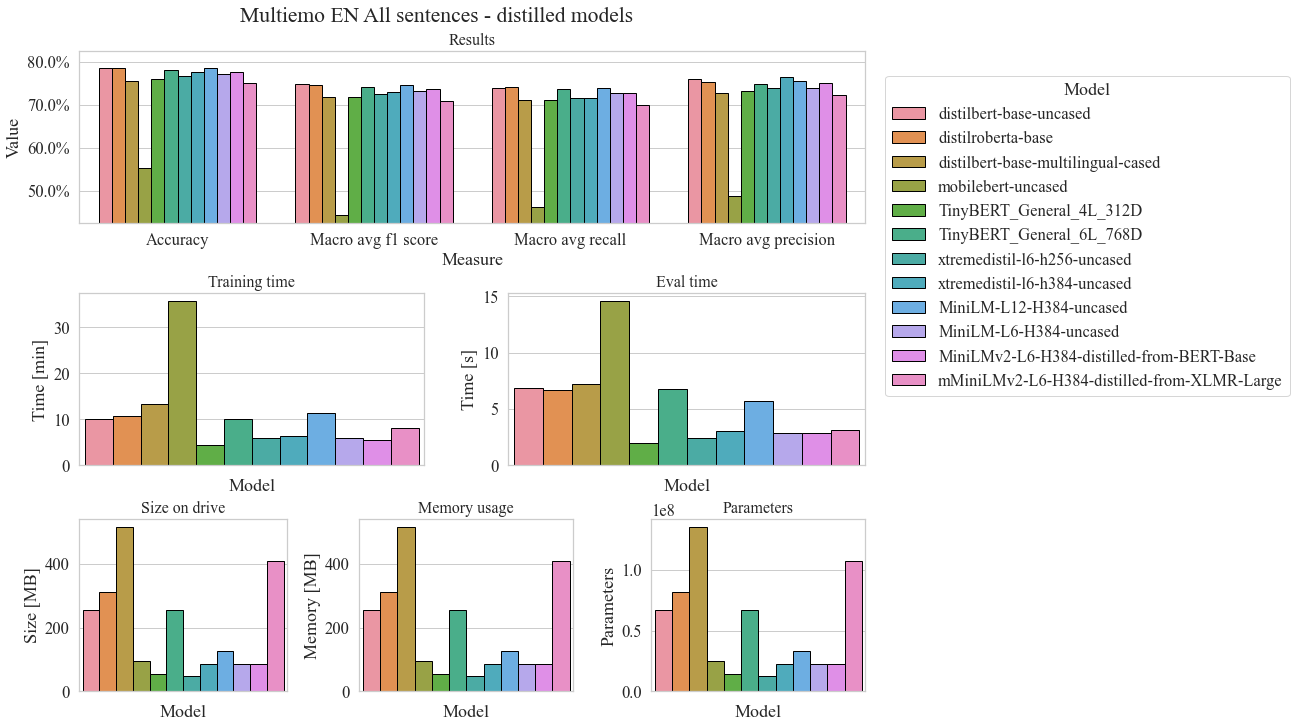

In [9]:
models = ['distilbert-base-uncased',
          'distilroberta-base',
          'distilbert-base-multilingual-cased',
          'mobilebert-uncased',
          'TinyBERT_General_4L_312D', 'TinyBERT_General_6L_768D',
          'xtremedistil-l6-h256-uncased', 'xtremedistil-l6-h384-uncased',
          'MiniLM-L12-H384-uncased', 'MiniLM-L6-H384-uncased',
          'MiniLMv2-L6-H384-distilled-from-BERT-Base',
          'mMiniLMv2-L6-H384-distilled-from-XLMR-Large',
         ]
visualize_models(df, models, suptitle='Multiemo EN All sentences - distilled models')

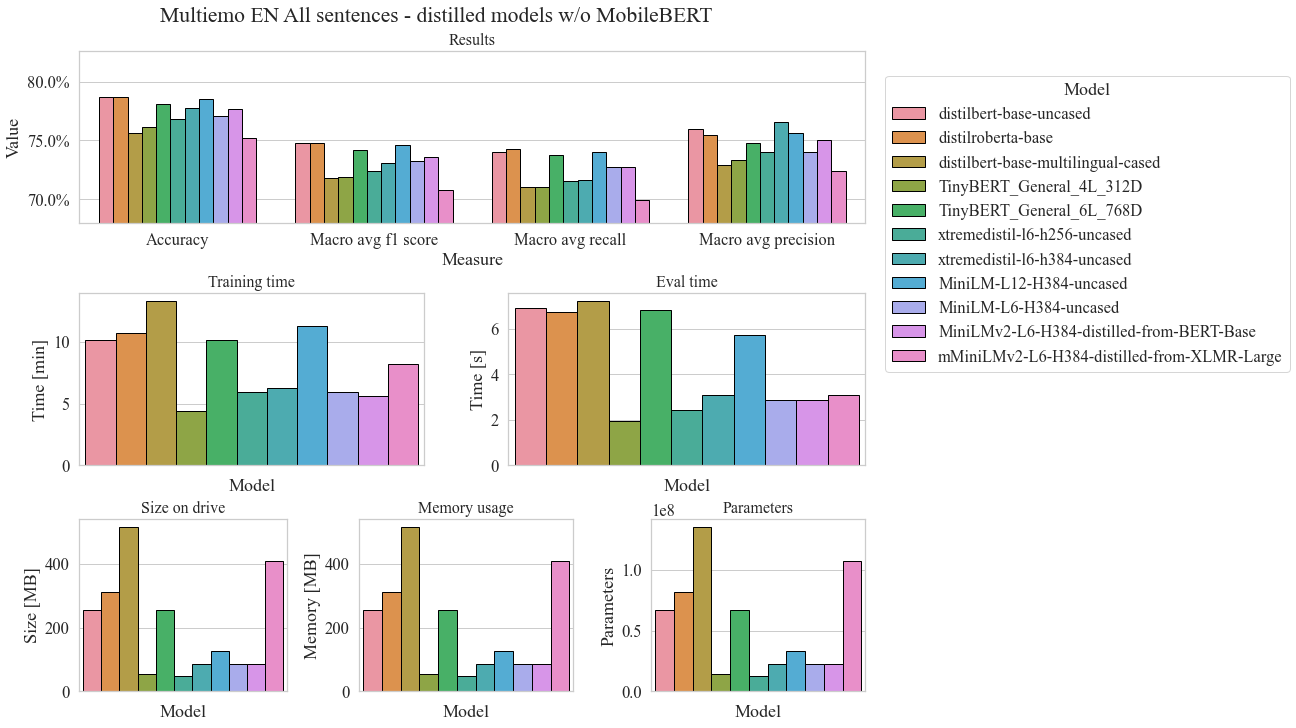

In [10]:
models = ['distilbert-base-uncased',
          'distilroberta-base',
          'distilbert-base-multilingual-cased',
          'TinyBERT_General_4L_312D', 'TinyBERT_General_6L_768D',
          'xtremedistil-l6-h256-uncased', 'xtremedistil-l6-h384-uncased',
          'MiniLM-L12-H384-uncased', 'MiniLM-L6-H384-uncased',
          'MiniLMv2-L6-H384-distilled-from-BERT-Base',
          'mMiniLMv2-L6-H384-distilled-from-XLMR-Large',
         ]
visualize_models(df, models, suptitle='Multiemo EN All sentences - distilled models w/o MobileBERT')

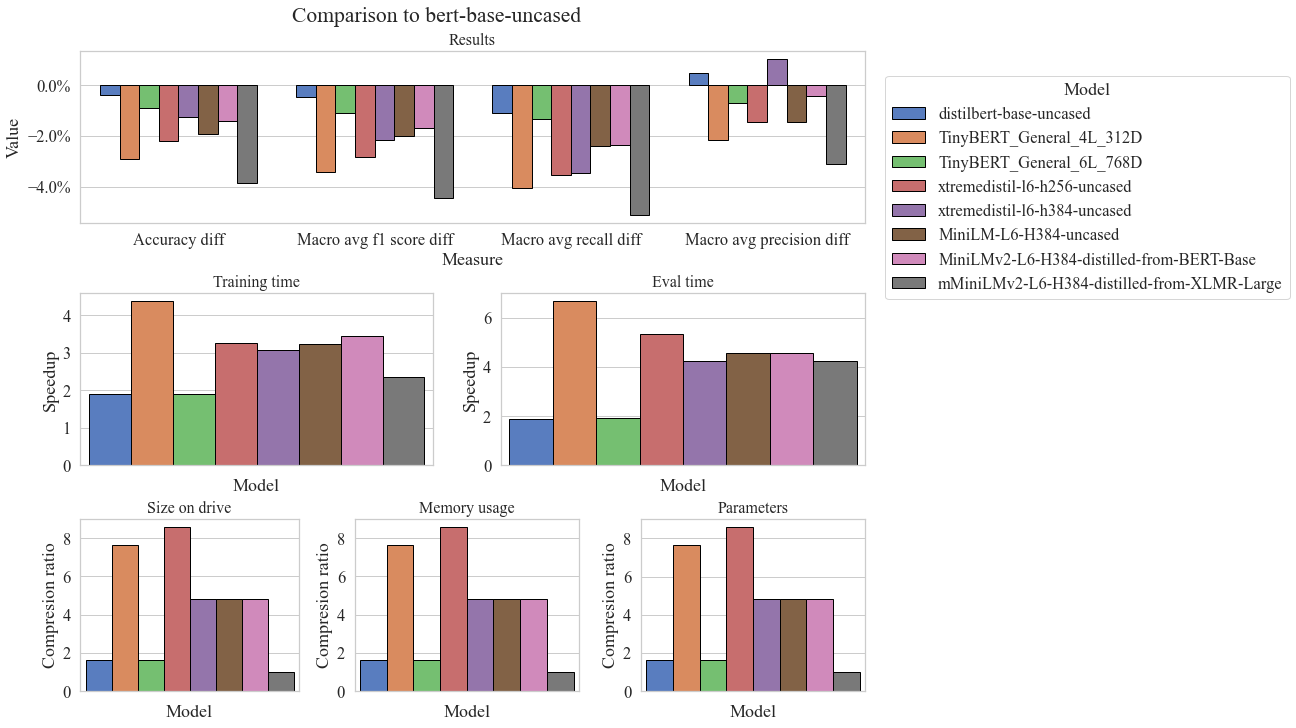

In [11]:
ref_model = 'bert-base-uncased'
models = ['distilbert-base-uncased',
              'TinyBERT_General_4L_312D', 
              'TinyBERT_General_6L_768D',
              'xtremedistil-l6-h256-uncased', 
              'xtremedistil-l6-h384-uncased',
              'MiniLM-L6-H384-uncased',
              'MiniLMv2-L6-H384-distilled-from-BERT-Base',
          'mMiniLMv2-L6-H384-distilled-from-XLMR-Large'
         ]
visualize_models_comparision(df, ref_model, models, suptitle='Comparison to {}'.format(ref_model))

# Multiemo PL - All sentences

In [12]:
file_name = 'results-multiemo_pl_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df = load_results_df(file_path)

with pd.option_context('display.max_columns', None):
    display(df)

,name,model_name,task_name,epochs,batch_size,learning_rate,weight_decay,warmup_steps,max_seq_length,training_time,accuracy,eval_time,z_amb_precision,z_amb_recall,z_amb_f1-score,z_amb_support,z_minus_m_precision,z_minus_m_recall,z_minus_m_f1-score,z_minus_m_support,z_plus_m_precision,z_plus_m_recall,z_plus_m_f1-score,z_plus_m_support,z_zero_precision,z_zero_recall,z_zero_f1-score,z_zero_support,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,model_size,gpu_memory_used,memory,parameters,model_size [MB],memory [MB],training_time_in_minutes
0,multiemo_pl_all_sentence-run-2,bert-base-multilingual-cased,multiemo_pl_all_sentence,3,8,0.00005,0.01,0,512,1964.320126,0.412359,16.627398,0.000000,0.000000,0.000000,681,0.509728,0.617051,0.558278,2123,0.333543,0.695795,0.450926,1522,0.000000,0.000000,0.000000,1419,0.210818,0.328212,0.252301,5745,0.276728,0.412359,0.325768,5745,711510189,8716.0,711430160,177856516,678.548993,678.472672,32.738669
1,multiemo_pl_all_sentence-run-3,bert-base-multilingual-cased,multiemo_pl_all_sentence,6,8,0.00005,0.01,0,512,3818.286910,0.716101,16.384561,0.505300,0.419971,0.458701,681,0.744323,0.772021,0.757919,2123,0.713938,0.770696,0.741232,1522,0.761619,0.715997,0.738104,1419,0.681295,0.669671,0.673989,5745,0.712212,0.716101,0.713135,5745,711510189,8716.0,711430160,177856516,678.548993,678.472672,63.638115
2,multiemo_pl_all_sentence-run-1,bert-base-multilingual-cased,multiemo_pl_all_sentence,3,8,0.00005,0.01,0,512,6320.268218,0.746562,69.591829,0.578641,0.437592,0.498328,681,0.767865,0.814885,0.790676,2123,0.768182,0.777267,0.772698,1522,0.750174,0.759690,0.754902,1419,0.716215,0.697358,0.704151,5745,0.741149,0.746562,0.742423,5745,711510189,8716.0,711430160,177856516,678.548993,678.472672,105.337804
3,multiemo_pl_all_sentence-run-2,distilbert-base-multilingual-cased,multiemo_pl_all_sentence,3,16,0.00005,0.01,0,512,2876.189362,0.748999,31.058786,0.590038,0.452276,0.512053,681,0.727921,0.865756,0.790878,2123,0.802252,0.749014,0.774720,1522,0.796398,0.716702,0.754451,1419,0.729152,0.695937,0.708025,5745,0.748182,0.748999,0.744549,5745,541351025,8716.0,541310992,135327748,516.272569,516.234390,47.936489
4,multiemo_pl_all_sentence-run-3,distilbert-base-multilingual-cased,multiemo_pl_all_sentence,3,16,0.00005,0.01,0,512,927.573509,0.739600,8.606630,0.551095,0.443465,0.491456,681,0.756614,0.808290,0.781599,2123,0.764706,0.768725,0.766710,1522,0.758399,0.747710,0.753016,1419,0.707703,0.692048,0.698195,5745,0.734837,0.739600,0.736202,5745,541351025,8730.0,541310992,135327748,516.272569,516.234390,15.459558
5,multiemo_pl_all_sentence-run-1,distilbert-base-multilingual-cased,multiemo_pl_all_sentence,3,16,0.00005,0.01,0,512,2879.252849,0.748651,31.055493,0.627273,0.405286,0.492417,681,0.710457,0.886481,0.788768,2123,0.778510,0.775953,0.777229,1522,0.844601,0.677942,0.752150,1419,0.740210,0.686416,0.702641,5745,0.751759,0.748651,0.741538,5745,541351025,8730.0,541310992,135327748,516.272569,516.234390,47.987547


In [13]:
df[cols_to_display]

,task_name,model_name,accuracy,macro avg_f1-score,macro avg_recall,macro avg_precision,training_time,eval_time,model_size [MB],gpu_memory_used,memory [MB],parameters
0,multiemo_pl_all_sentence,bert-base-multilingual-cased,0.412359,0.252301,0.328212,0.210818,1964.320126,16.627398,678.548993,8716.0,678.472672,177856516
1,multiemo_pl_all_sentence,bert-base-multilingual-cased,0.716101,0.673989,0.669671,0.681295,3818.286910,16.384561,678.548993,8716.0,678.472672,177856516
2,multiemo_pl_all_sentence,bert-base-multilingual-cased,0.746562,0.704151,0.697358,0.716215,6320.268218,69.591829,678.548993,8716.0,678.472672,177856516
3,multiemo_pl_all_sentence,distilbert-base-multilingual-cased,0.748999,0.708025,0.695937,0.729152,2876.189362,31.058786,516.272569,8716.0,516.234390,135327748
4,multiemo_pl_all_sentence,distilbert-base-multilingual-cased,0.739600,0.698195,0.692048,0.707703,927.573509,8.606630,516.272569,8730.0,516.234390,135327748
5,multiemo_pl_all_sentence,distilbert-base-multilingual-cased,0.748651,0.702641,0.686416,0.740210,2879.252849,31.055493,516.272569,8730.0,516.234390,135327748


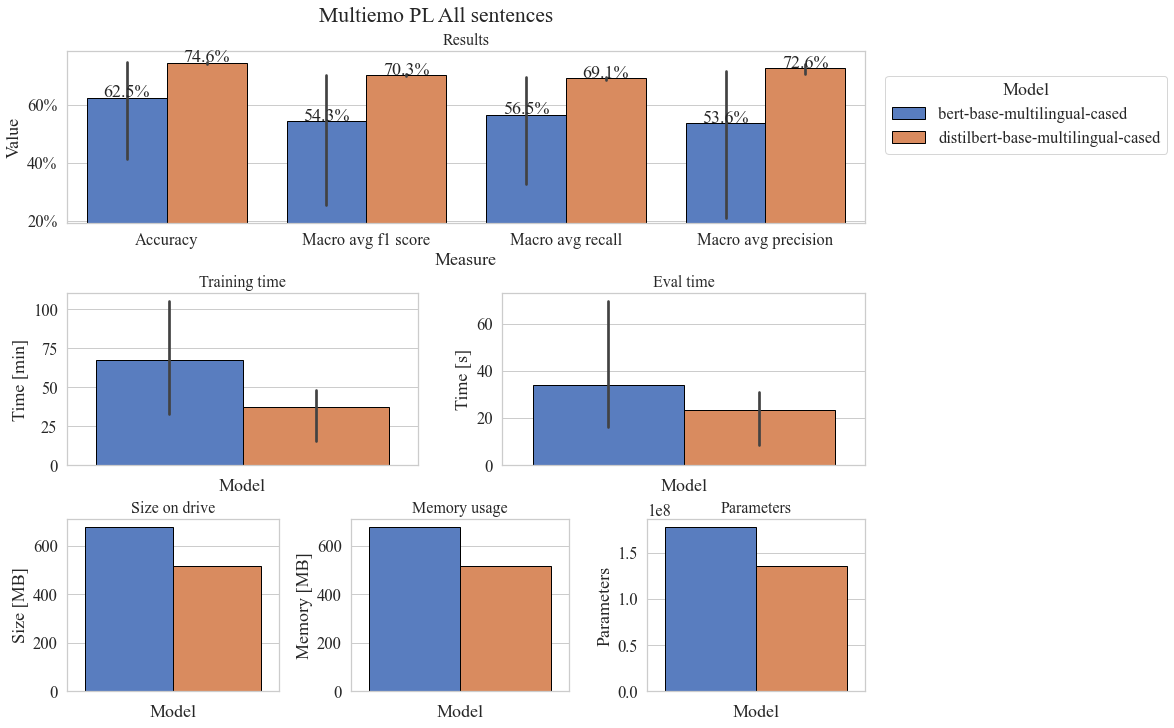

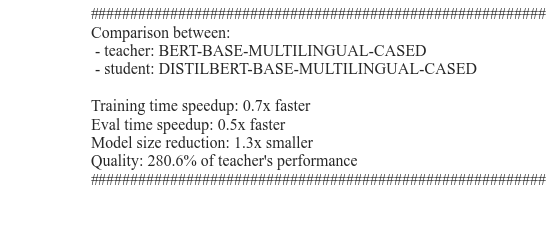

In [14]:
models = ['bert-base-multilingual-cased', 'distilbert-base-multilingual-cased']
visualize_models(df, models, suptitle='Multiemo PL All sentences')
print_model_comparison(df, models[0], models[1])